<a href="https://colab.research.google.com/github/dltnqls9788/Pytorch/blob/main/%08CIFAR10_ResNet(3_min_pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경 설정하기

In [1]:
# 필요한 라이브러리 및 모듈 불러오기 
import torch
import torchsummary
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F 
from torchvision import transforms, datasets, utils

import matplotlib.pyplot as plt
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
# hyper parameters
EPOCHS = 300
BATCH_SIZE = 128

## 데이터 불러오기 및 전처리

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                     train=True,
                     download=True,
                     transform=transforms.Compose([
                            # 오버피팅 방지 
                            transforms.RandomCrop(32, padding=4), # 이미지 자르기
                            transforms.RandomHorizontalFlip(), # 무작위로 이미지의 오른쪽과 왼쪽을 뒤집음
                            transforms.ToTensor(), # 이미지를 파이토치 텐서로 변환
                            transforms.Normalize((0.5,0.5,0.5), # 정규화 
                                                 (0.5,0.5,0.5))])),
    batch_size = BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                    train=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,0.5,0.5),
                                             (0.5,0.5,0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [5]:
dataiter = iter(train_loader) # iter() : 반복문 안에서 이용할 수 있도록 만들어줌 
images, labels = next(dataiter) # next() : 배치 1개 가져오기 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


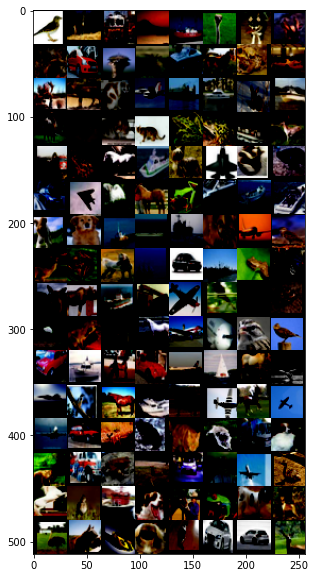

In [6]:
img = utils.make_grid(images, padding=0)
npimg = img.numpy() # img는 파이토치 텐서이므로 맷플롯립과 호환이 되는 넘파이 행렬로 변환
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [7]:
class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, stride=1):
      super(BasicBlock, self).__init__()
      self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,stride=stride, padding=1, bias=False)
      self.bn1 = nn.BatchNorm2d(planes)
      self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(planes)

      self.shortcut = nn.Sequential()
      if stride != 1 or in_planes != planes:
          self.shortcut = nn.Sequential(
              nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(planes)
          )

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
      out += self.shortcut(x)
      out = F.relu(out)
      return out

In [8]:
class ResNet(nn.Module):
  def __init__(self, num_classes=10):
      super(ResNet, self).__init__()
      self.in_planes=16

      self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn1 = nn.BatchNorm2d(16)

      self.layer1 = self._make_layer(16, 2, stride=1)
      self.layer2 = self._make_layer(32, 2, stride=2)
      self.layer3 = self._make_layer(64, 2, stride=2)
      self.linear = nn.Linear(64, num_classes)

  def _make_layer(self, planes, num_blocks, stride):
      strides = [stride] + [1]*(num_blocks-1)
      layers = []
      for stride in strides:
          layers.append(BasicBlock(self.in_planes, planes, stride))
          self.in_planes = planes
      return nn.Sequential(*layers)

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.layer1(out)
      out = self.layer2(out)
      out = self.layer3(out)
      out = F.avg_pool2d(out, 8)
      out = out.view(out.size(0), -1)
      out = self.linear(out)
      return out 

In [9]:
model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005)
# 학습률 감소 기법(learning rate decay)
# 학습이 진행하면서 최적화 함수의 학습률을 점점 낮춰서 더 정교하게 최적화한다.
# 이폭 50번 호출될 때 학습률에 0.1(gamma) 곱한다. 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50,gamma=0.1)

In [10]:
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 32, 16, 16]           4,608
      BatchNorm2d-14           [-1, 32,

In [11]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad() # 반복 때마다 기울기 새로 계산 
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward() # 역전파 알고리즘(기울기 계산)
        optimizer.step() # 구한 기울깃값으로 모델의 학습 파라미터 갱신


def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0 
    with torch.no_grad(): # 평가는 기울기 계산 x
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)


            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1] # output.max() = 가장 큰 값, 그 값이 있는 자리(인덱스)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [12]:
for epoch in range(1, EPOCHS+1):
    scheduler.step()
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print('[{}] Test Loss:{:.4f}, Accuracy:{:.2f}%'.format(epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1] Test Loss:1.4689, Accuracy:48.67%
[2] Test Loss:1.2612, Accuracy:57.30%
[3] Test Loss:1.0237, Accuracy:66.03%
[4] Test Loss:0.7987, Accuracy:73.38%
[5] Test Loss:1.0743, Accuracy:65.67%
[6] Test Loss:0.8305, Accuracy:72.42%
[7] Test Loss:0.8704, Accuracy:72.39%
[8] Test Loss:0.6947, Accuracy:76.37%
[9] Test Loss:0.8855, Accuracy:71.84%
[10] Test Loss:0.6923, Accuracy:77.49%
[11] Test Loss:1.2291, Accuracy:65.00%
[12] Test Loss:0.7709, Accuracy:73.89%
[13] Test Loss:0.7003, Accuracy:76.15%
[14] Test Loss:0.8856, Accuracy:70.78%
[15] Test Loss:0.7342, Accuracy:75.82%
[16] Test Loss:0.6788, Accuracy:77.75%
[17] Test Loss:0.6501, Accuracy:78.27%
[18] Test Loss:0.8721, Accuracy:73.13%
[19] Test Loss:0.8131, Accuracy:74.22%
[20] Test Loss:0.7728, Accuracy:74.70%
[21] Test Loss:0.7529, Accuracy:74.57%
[22] Test Loss:0.7675, Accuracy:75.84%
[23] Test Loss:0.6873, Accuracy:77.28%
[24] Test Loss:0.6762, Accuracy:77.12%
[25] Test Loss:0.7136, Accuracy:76.32%
[26] Test Loss:0.9519, Accuracy:68